In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from sklearn.utils import resample


# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

c:\Users\ASUS\anaconda3\envs\python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
df = pd.read_csv('data - data.csv').drop(columns=['Unnamed: 3'])
df.shape



(31460, 3)

In [8]:
df.head()

,comment,label,rate
0,Áo bao đẹp ạ!!,POS,5
1,Tuyệt vời !,POS,5
2,2day ao khong giong trong.,NEG,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5
4,"Vải đẹp, dày dặn.",POS,5


In [9]:
# Let's check for missing values 
df.isnull().sum()

comment    0
label      0
rate       0
dtype: int64

In [10]:
df.rate

0        5
1        5
2        1
3        5
4        5
        ..
31455    1
31456    5
31457    5
31458    4
31459    5
Name: rate, Length: 31460, dtype: int64

Text(0.5, 0, 'review score')

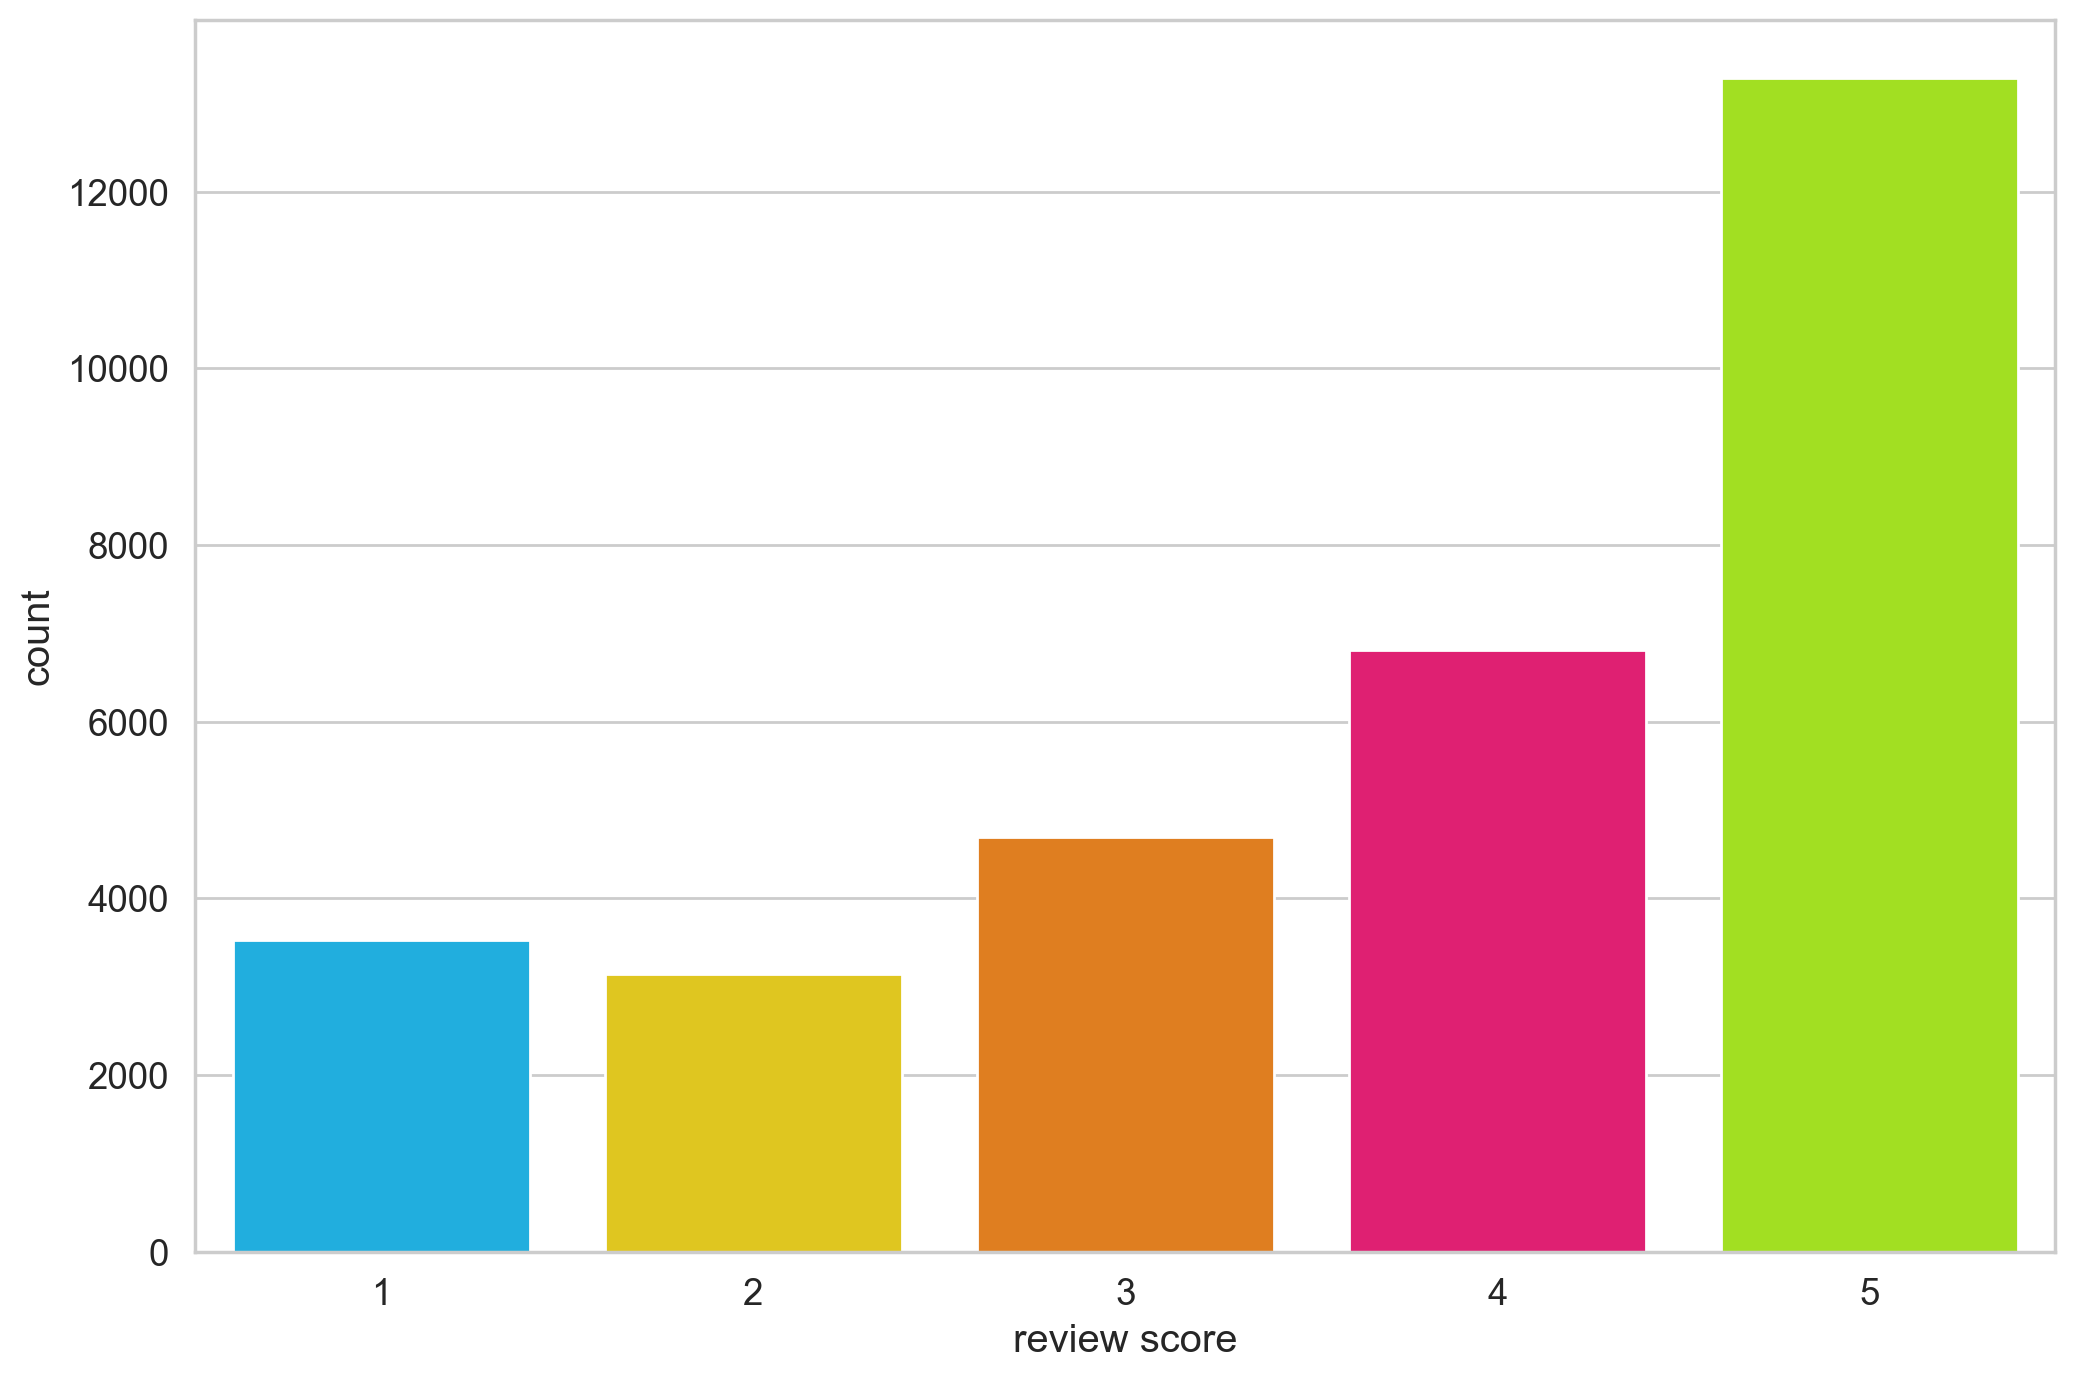

In [11]:
# # Let's have a look at the class balance.
sns.countplot( x='rate',data = df)
plt.xlabel('review score')

In [12]:
df

,comment,label,rate
0,Áo bao đẹp ạ!!,POS,5
1,Tuyệt vời !,POS,5
2,2day ao khong giong trong.,NEG,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5
4,"Vải đẹp, dày dặn.",POS,5
...,...,...,...
31455,Không đáng tiền.,NEG,1
31456,Quần rất đẹp.,POS,5
31457,Hàng đẹp đúng giá tiền.,POS,5
31458,Chất vải khá ổn.,POS,4


In [13]:
df = df[df['rate'] != 3]
df

,comment,label,rate
0,Áo bao đẹp ạ!!,POS,5
1,Tuyệt vời !,POS,5
2,2day ao khong giong trong.,NEG,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5
4,"Vải đẹp, dày dặn.",POS,5
...,...,...,...
31455,Không đáng tiền.,NEG,1
31456,Quần rất đẹp.,POS,5
31457,Hàng đẹp đúng giá tiền.,POS,5
31458,Chất vải khá ổn.,POS,4


Text(0.5, 0, 'review score')

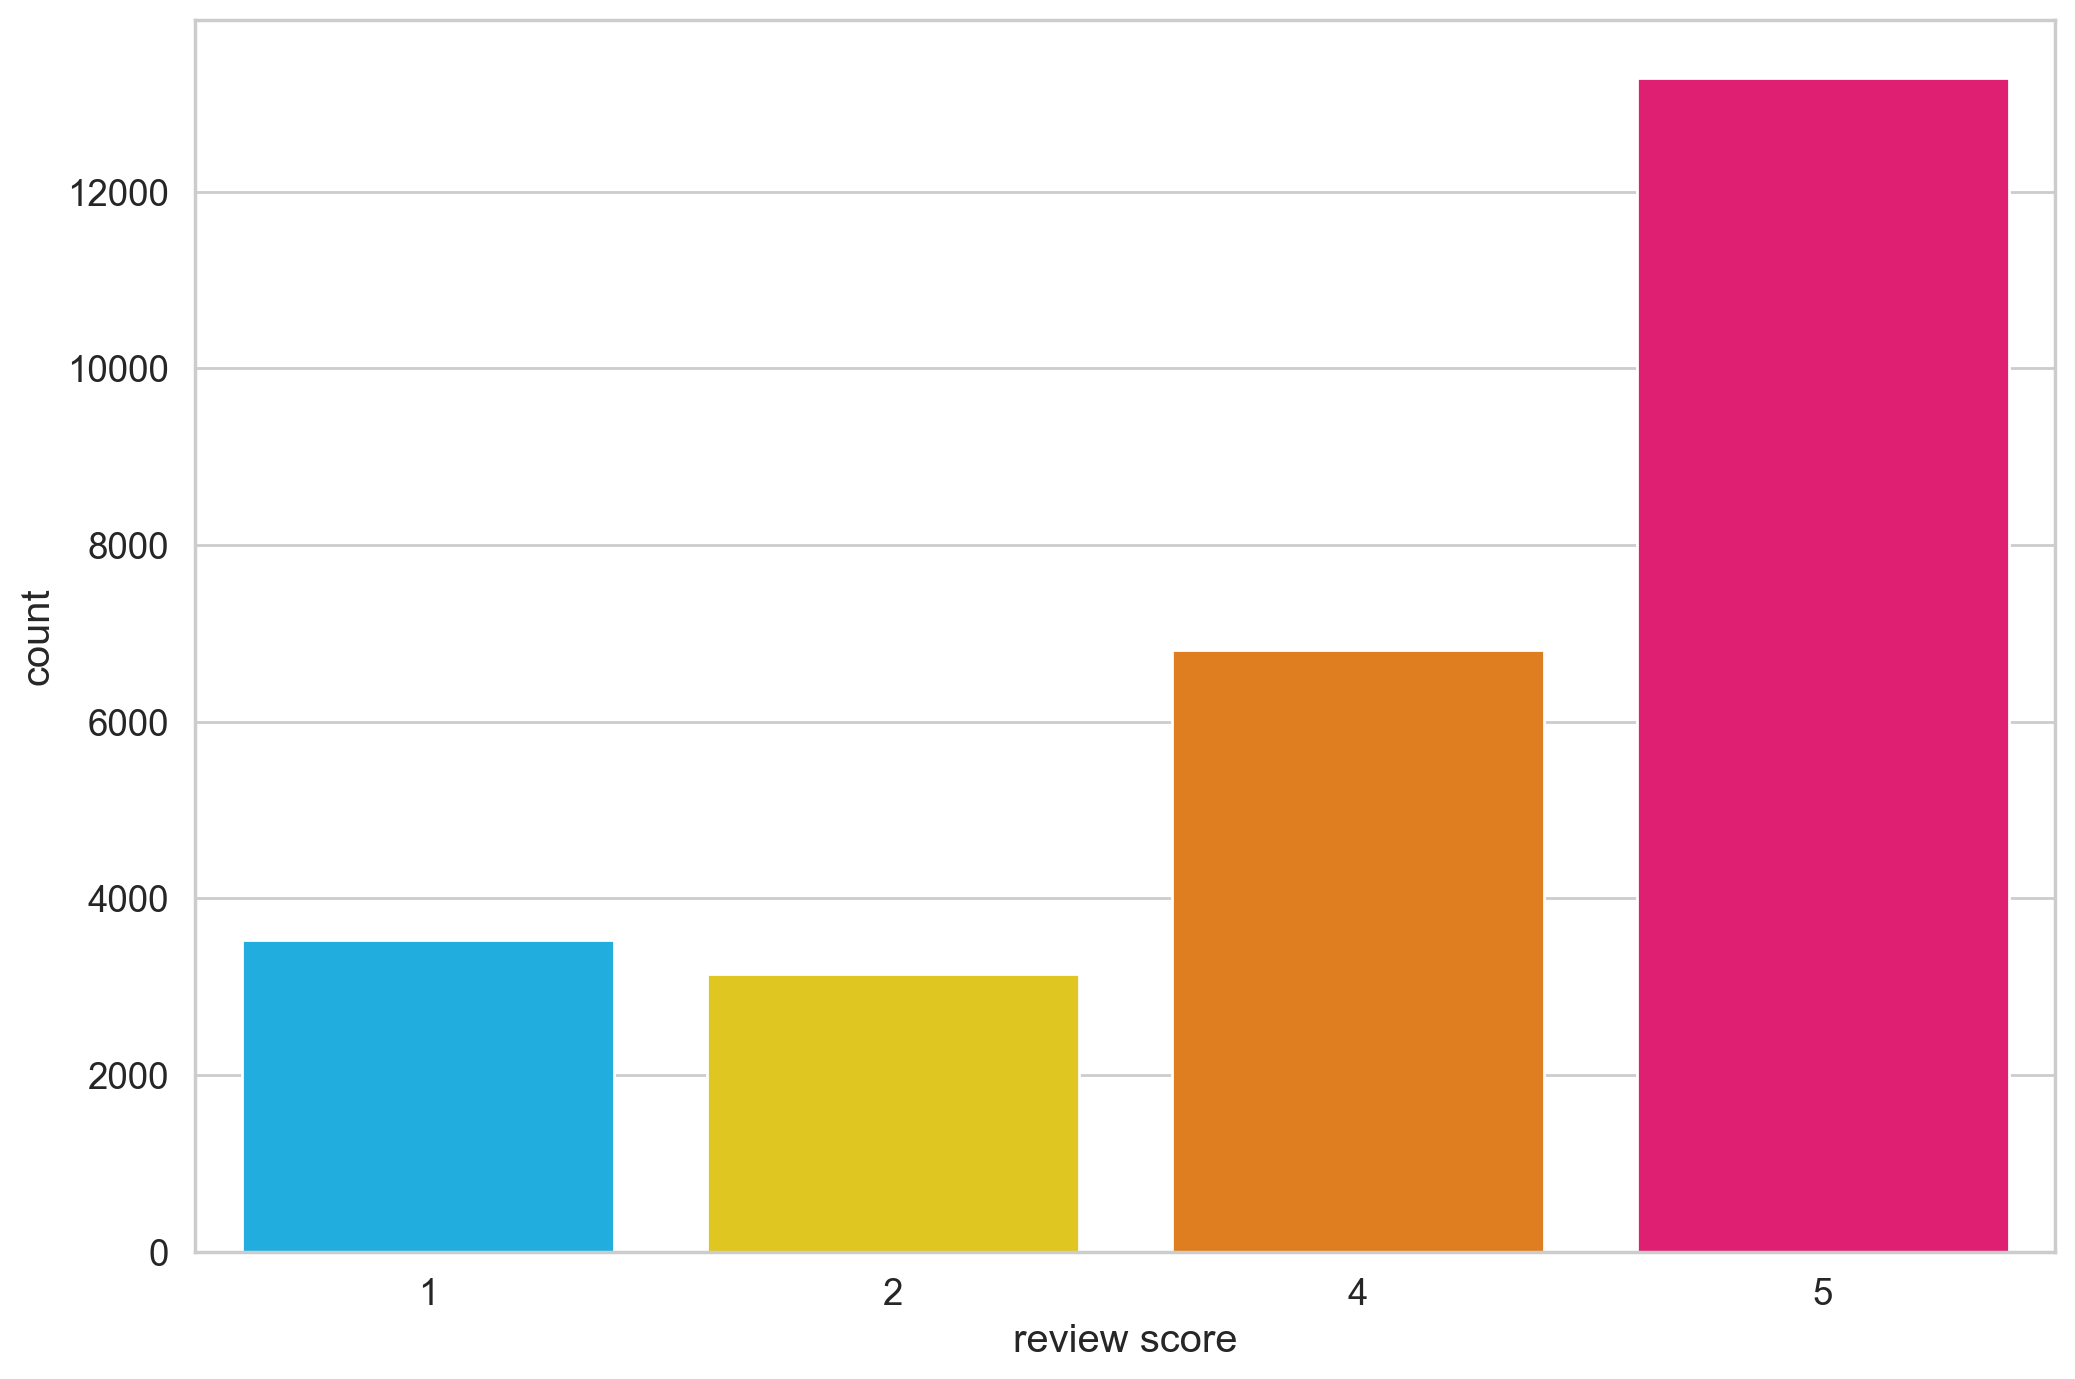

In [14]:
# # Let's have a look at the class balance.
sns.countplot( x='rate',data = df)
plt.xlabel('review score')

In [15]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    else:
        return 1

# Apply to the dataset 
df['sentiment'] = df.rate.apply(to_sentiment)

In [16]:
df

,comment,label,rate,sentiment
0,Áo bao đẹp ạ!!,POS,5,1
1,Tuyệt vời !,POS,5,1
2,2day ao khong giong trong.,NEG,1,0
3,"Mùi thơm,bôi lên da mềm da.",POS,5,1
4,"Vải đẹp, dày dặn.",POS,5,1
...,...,...,...,...
31455,Không đáng tiền.,NEG,1,0
31456,Quần rất đẹp.,POS,5,1
31457,Hàng đẹp đúng giá tiền.,POS,5,1
31458,Chất vải khá ổn.,POS,4,1


Text(0.5, 0, 'review sentiment')

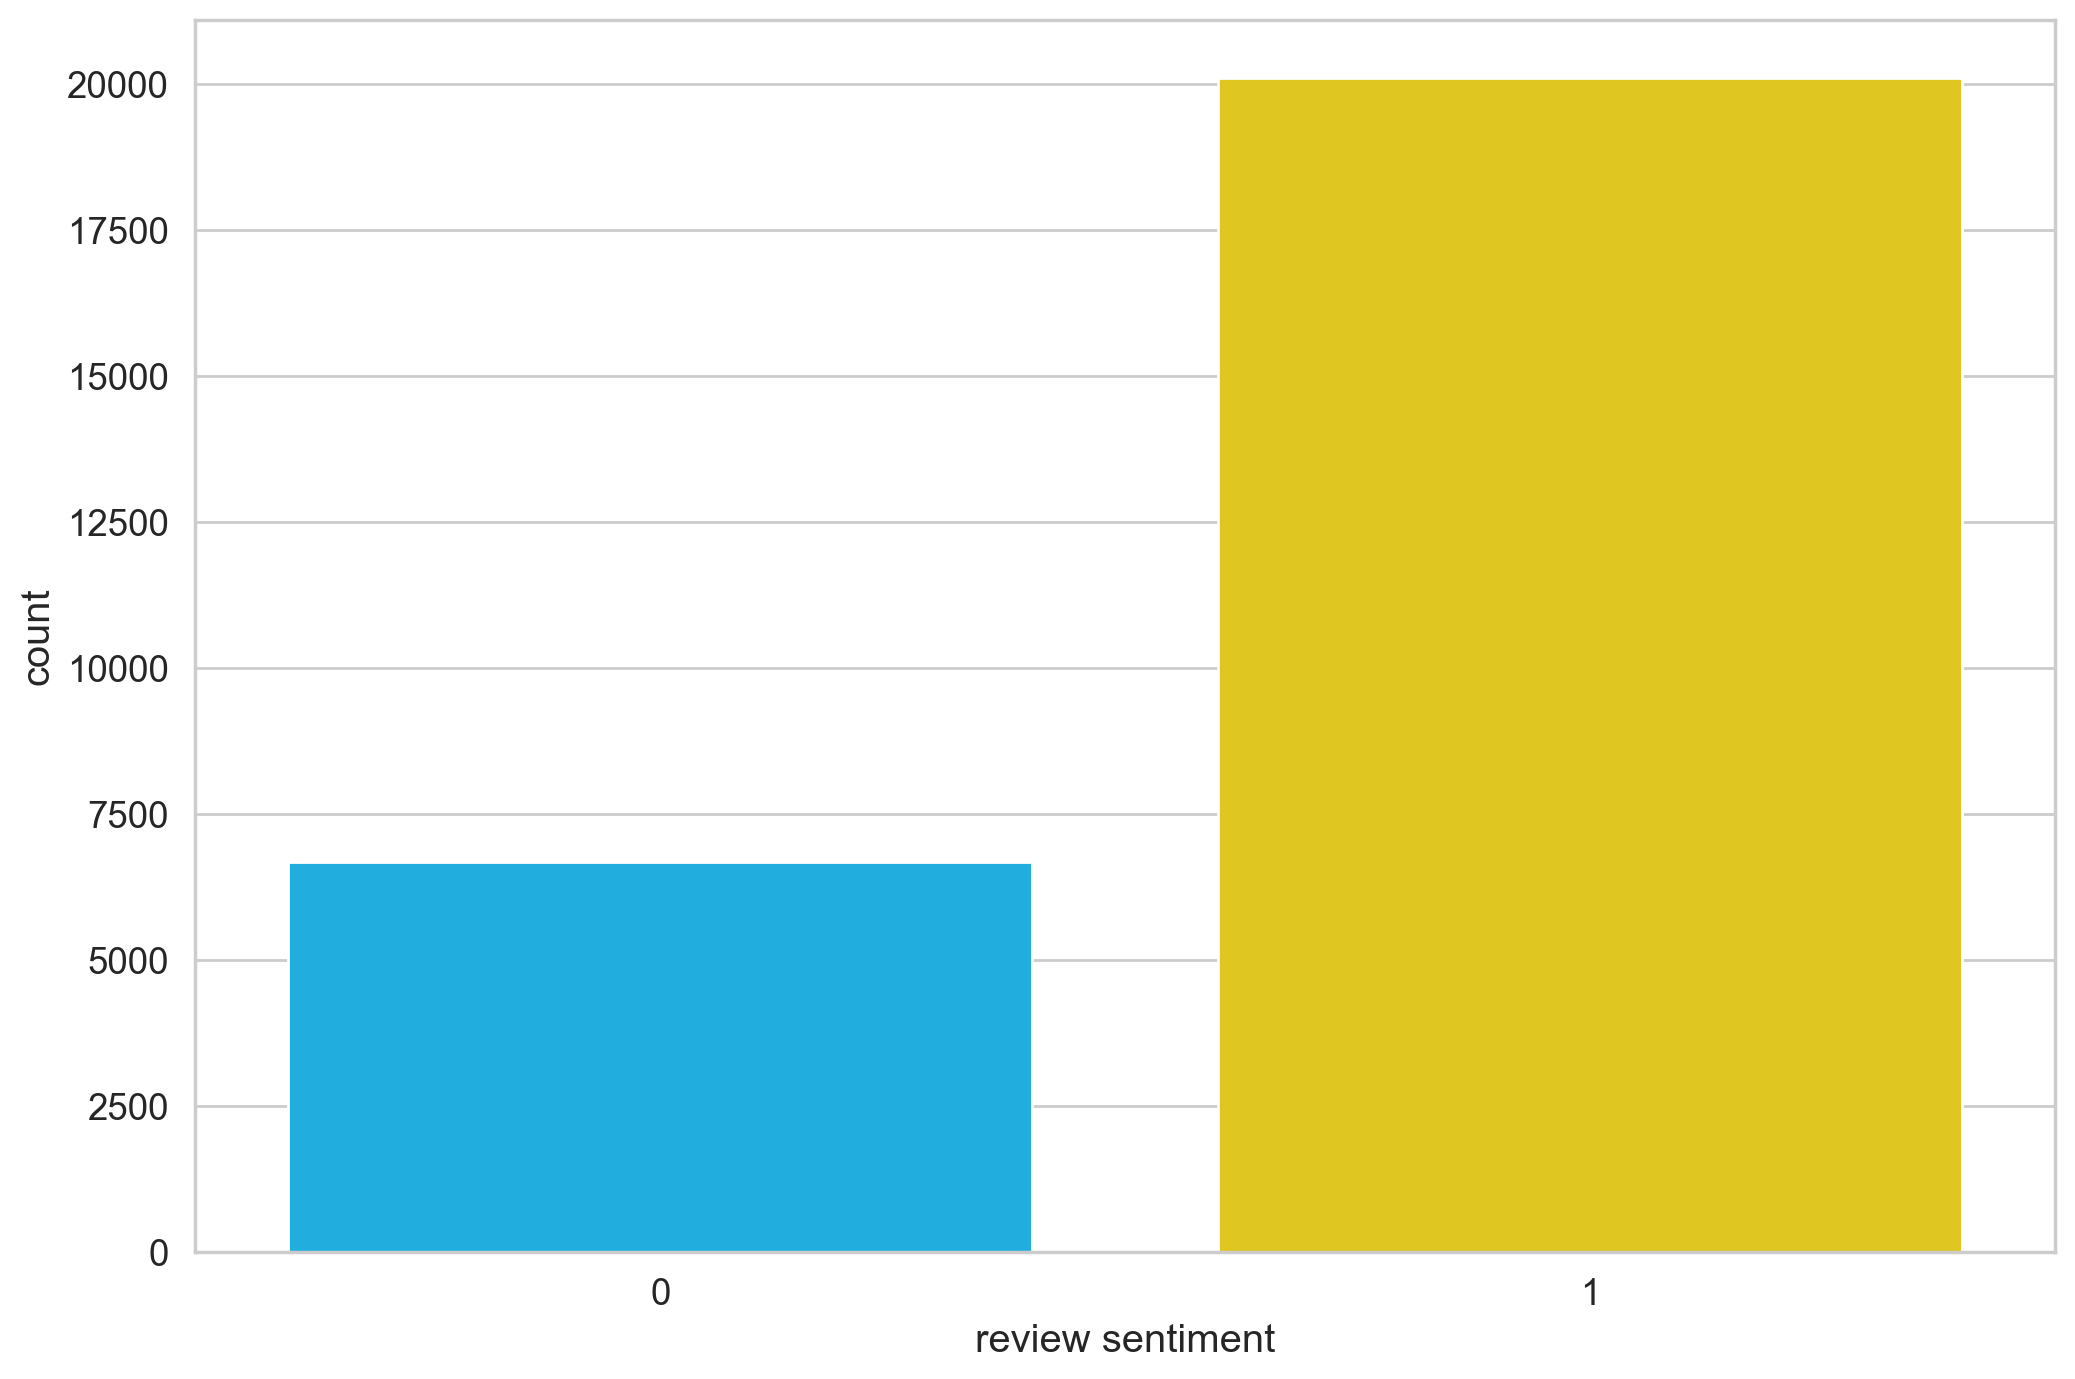

In [17]:
# # Plot the distribution
class_names = ['negative', 'positive']
'''
- Tạo 2 class: Negative n Positive
'''
sns.countplot( x='sentiment',data = df)
plt.xlabel('review sentiment')
# ax.set_xticklabels(class_names)

In [18]:
df['sentiment'].value_counts()

1    20093
0     6669
Name: sentiment, dtype: int64

In [20]:
df_majority = df[(df['sentiment']==1)] 
df_minority = df[(df['sentiment']==0)]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 20093, # to match majority class
                                 random_state=42)
df1 = pd.concat([df_minority_upsampled, df_majority])


In [21]:
df1['sentiment'].value_counts()

0    20093
1    20093
Name: sentiment, dtype: int64

In [22]:
# Set the model name
MODEL_NAME = 'bert-base-cased' # Assign string "..." to the model name 

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
''' 
Tokenizer using BERT model.
- Tokenizer breaks down text -> smaller units (tokens) n convert into numerical representations that can be fed into machine learning models
- BERT tokenizers are specifically designed to handle natural language processing tasks.
'''

' \nTokenizer using BERT model.\n- Tokenizer breaks down text -> smaller units (tokens) n convert into numerical representations that can be fed into machine learning models\n- BERT tokenizers are specifically designed to handle natural language processing tasks.\n'

In [23]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
''' 
Separator: mark the end of a sentence or segment in BERT, understand boundaries btw different parts of input
For example, the sentence “John lives in New York.” would be tokenized as: [CLS] John lives in New York. [SEP]
'''
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
'''
placed at the beginning of each input sequence
'''
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
''' 
is used to ensure that all input sequences have the same length
'''
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set
'''
is used for out-of-vocabulary (OOV) words
If a word is not present in BERT’s vocabulary, it is replaced with the [UNK] token.
'''

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


'\nis used for out-of-vocabulary (OOV) words\nIf a word is not present in BERT’s vocabulary, it is replaced with the [UNK] token.\n'

In [24]:
# Store length of each review 
token_lens = [] # Initialize an empty list

# Iterate through the content slide
for txt in df1.comment: # iterate thr each rv in df.comment
    tokens = tokenizer.encode(txt, max_length=512) # tokenize text, maximum length (tokenized sequence) = 512
    token_lens.append(len(tokens)) # compute length of the resulting tokenized sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [25]:
MAX_LEN = 160 


In [26]:
class GPReviewDataset(Dataset):
    # this class creates a PyTorch dataset for sentiment analysis
    
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews # list rv texts
        self.targets = targets # list of corresponding target labels
        self.tokenizer = tokenizer # encode the review texts.
        self.max_len = max_len # maximum length for tokenized sequences
    
    # Length magic method
    def __len__(self):
        return len(self.reviews) # Returns the total number of samples in the dataset
    
    # get item magic method
    def __getitem__(self, item):
        '''
        Retrieves a specific sample from the dataset  
        '''
        review = str(self.reviews[item]) # Convert rv text -> string
        target = self.targets[item] # Retrieves the corresponding target label.
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [51]:
df_train, df_test = train_test_split(df1, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)
# Split the dataset into training and test sets

(32148, 4) (4019, 4) (4019, 4)


In [28]:
def create_data_loader(df1, tokenizer, max_len, batch_size):
    ''' 
    - df1: A DataFrame containing the data.
    - tokenizer: A tokenizer object used to convert text into tokens
    - max_len: The maximum length of the tokenized sequences.
    - batch_size: The number of samples per batch to load.
    '''
    ds = GPReviewDataset(
        reviews=df1.comment.to_numpy(), # Converts the ‘comment’ column of the DataFrame to a NumPy array
        targets=df1.sentiment.to_numpy(), # Converts the ‘sentiment’ column of the DataFrame to a NumPy array
        tokenizer=tokenizer, # The tokenizer object used to tokenize the reviews
        max_len=max_len # The maximum length of the tokenized sequences
    )
    
    return DataLoader( # PyTorch DataLoader that loads data from the dataset in batches
        ds, # The dataset created above.
        batch_size=batch_size, # The number of samples per batch
        num_workers=0 # number of subprocesses to use for data loading. Setting it to 0 means that the data will be loaded in the main process.
    )

In [29]:
# Create train, test and val data loaders
BATCH_SIZE = 16 # data fed into the model will contain 16 samples
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) 
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



In [30]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [31]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)
''' 
- bert_model: This is the variable where the BERT model will be stored.
- BertModel: This is a class from the Hugging Face Transformers library that represents the BERT model. 
It provides the architecture and methods to work with BERT
- from_pretrained(MODEL_NAME): This method loads a pre-trained BERT model
+ MODEL_NAME: This is a string that specifies the name of the pre-trained model you want to load, in this case is bert-base-cased
+ from_pretrained method downloads the model weights and configuration from the Hugging Face model hub and initializes the BertModel with these 
pre-trained parameters.
'''

In [32]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
  # This is a custom class that inherits from nn.Module, which is the base class for all neural network modules in PyTorch
    
    # Constructor class 
    def __init__(self, n_classes): 
      ''' 
      __init__ : constructor method that initializes the model.
      n_classes: specify the number of output classes for the classifier.
      '''
      super(SentimentClassifier, self).__init__() # This calls the constructor of the parent class (nn.Module).
      self.bert = BertModel.from_pretrained(MODEL_NAME) # Loads a pre-trained BERT model using the specified MODEL_NAME.
      self.drop = nn.Dropout(p=0.3) # Adds a dropout layer with a dropout probability of 0.3 to prevent overfitting
      self.out = nn.Linear(self.bert.config.hidden_size, n_classes) 
      ''' 
       Defines a linear layer that maps the BERT output to the number of classes. The input size is the hidden size of the BERT model, 
       and the output size is n_classes
      '''
    
    # Forward propagation class
    def forward(self, input_ids, attention_mask):
      '''
      - forward: This method defines the forward pass of the model
      - input_ids: These are the tokenized input sequences
      - attention_mask: This mask indicates which tokens are actual data and which are padding.
      '''
      bert_output = self.bert(
        ''' 
        This gets the output from the BERT model. The pooler_output is a representation of the [CLS] token, 
        which is often used for classification tasks.
        '''
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      pooled_output = bert_output.pooler_output # Accessing the pooled output. This is the pooled output from the BERT model
      #  Add a dropout layer
      output = self.drop(pooled_output) # Applies the dropout layer to the pooled output and then passes it through the linear layer to get the final class scores.
      return self.out(output)


In [33]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
''' 
- Create an instance of the SentimentClassifier class
'''
model = model.to(device)
''' 
Moving the model to the appropriate device is crucial for efficient computation, especially when using a GPU for training.'''

In [34]:
# Number of hidden units
print(bert_model.config.hidden_size)
'''
This accesses the hidden_size attribute from the configuration of the bert_model. 
The hidden size is the dimensionality of the encoder layers and the pooler layer in the BERT model.
'''

768


In [35]:
# Number of iterations 
EPOCHS = 10 # the number of times the entire training dataset will pass through the model during training.

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
''' 
- the Adam optimizer that includes weight decay to reduce overfitting
- The learning rate is set to (2 \times 10^{-5}), and correct_bias is set to False to disable bias correction.
'''

total_steps = len(train_data_loader) * EPOCHS
'''
- Calculate the total number of training steps by multiplying the number of batches in the training data loader by the number of epochs.
'''

scheduler = get_linear_schedule_with_warmup(
    '''
    - scheduler adjusts the learning rate during training
    - Use a linear schedule with no warmup steps
    Mean: learning rate will decrease linearly from the initial value to zero over the course of training.
    '''
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = torch.nn.CrossEntropyLoss().to(device)
''' 
This sets the loss function to CrossEntropyLoss, which is commonly used for classification tasks and handle unbalanced datasets 
The loss function is moved to the specified device. 
'''

In [36]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() # set model to training mode
    losses = []
    correct_predictions = 0 # initialize an empty list to store loss values and a counter for correct predictions
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        '''
        This loop iterates over batches of data from the data loader. Each batch contains input IDs, attention masks, and targets, 
        which are moved to the GPU
        '''
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # The model processes the input IDs and attention masks to produce outputs.

        )
        
        _, preds = torch.max(outputs, dim=1) # gets the predicted class for each input.
        loss = loss_fn(outputs, targets) # The loss is calculated using the loss function.
        correct_predictions += torch.sum(preds == targets) # The number of correct predictions is updated.
        losses.append(loss.item()) # The loss value is appended to the losses list
        
        # Backward prop
        loss.backward() # This computes the gradients of the loss with respect to the model parameters.
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevents the gradients from exploding by clipping them to a maximum norm of 1.0.
        optimizer.step() # updates the model parameters based on the gradients.
        scheduler.step() # updates the learning rate according to the scheduler.
        optimizer.zero_grad() # resets the gradients to zero for the next iteration.
    
    return correct_predictions.double() / n_examples, np.mean(losses)
    # returns the accuracy (correct predictions divided by the number of examples) and the average loss over the epoch.

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # Set Model to Evaluation Mode
    
    losses = []
    correct_predictions = 0
    # initialize an empty list to store loss values and a counter for correct predictions.
    
    with torch.no_grad(): # disables gradient calculation, which reduces memory consumption and speeds up computations during evaluation.
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            ''' 
            loop iterates over batches of data from the data loader. Each batch contains input IDs, attention masks, and targets, which are moved to GPU
            '''
            
            # Get model ouptuts
            outputs = model( # model processes the input IDs and attention masks to produce outputs.
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1) # gets the predicted class for each input.
            loss = loss_fn(outputs, targets) # loss is calculated using the loss function.
            
            correct_predictions += torch.sum(preds == targets) # number of correct predictions is updated.
            losses.append(loss.item()) # The loss value is appended to the losses list.

            
    return correct_predictions.double() / n_examples, np.mean(losses)
    # returns the accuracy (correct predictions divided by the number of examples) and the average loss over the evaluation.

In [39]:
%%time # measures the time taken to execute the entire cell.

history = defaultdict(list) # history is a dictionary that will store lists of training and validation accuracies and losses for each epoch
best_accuracy = 0 #  keeps track of the highest validation accuracy achieved during training.

for epoch in range(EPOCHS): # This loop iterates over the number of epochs defined by EPOCHS.

    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    # This prints the current epoch number and a separator line for better readability.
    
    train_acc, train_loss = train_epoch( 
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    # This calls the train_epoch function to train the model for one epoch and returns the training accuracy and loss.
    
    print(f"Train loss {train_loss} accuracy {train_acc}") # This prints the training loss and accuracy for the current epoch.
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    # This calls the eval_model function to evaluate the model on the validation set and returns the validation accuracy and loss.
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print() # This prints the validation loss and accuracy for the current epoch.
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss) 
    # This appends the training and validation accuracies and losses to the history dictionary.

    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
    ''' 
    - If the current validation accuracy is higher than the best accuracy recorded so far, the model’s state is saved to a file named best_model_state.bin.
    - The best_accuracy variable is updated to the current validation accuracy.
    '''

Epoch 1/10
----------
Train loss 0.039561580813551246 accuracy 0.9897038696030858
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 2/10
----------
Train loss 0.03772738125564447 accuracy 0.9898282941396044
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 3/10
----------
Train loss 0.037742840904677034 accuracy 0.9900460370785119
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 4/10
----------
Train loss 0.03824593958578684 accuracy 0.9896727634689562
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 5/10
----------
Train loss 0.0352437333858616 accuracy 0.9903259922856789
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 6/10
----------
Train loss 0.03807593779492167 accuracy 0.9897038696030858
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 7/10
----------
Train loss 0.03985738177459156 accuracy 0.9892994898594003
Val   loss 0.2651527032412271 accuracy 0.9547151032595174

Epoch 8/10
--------

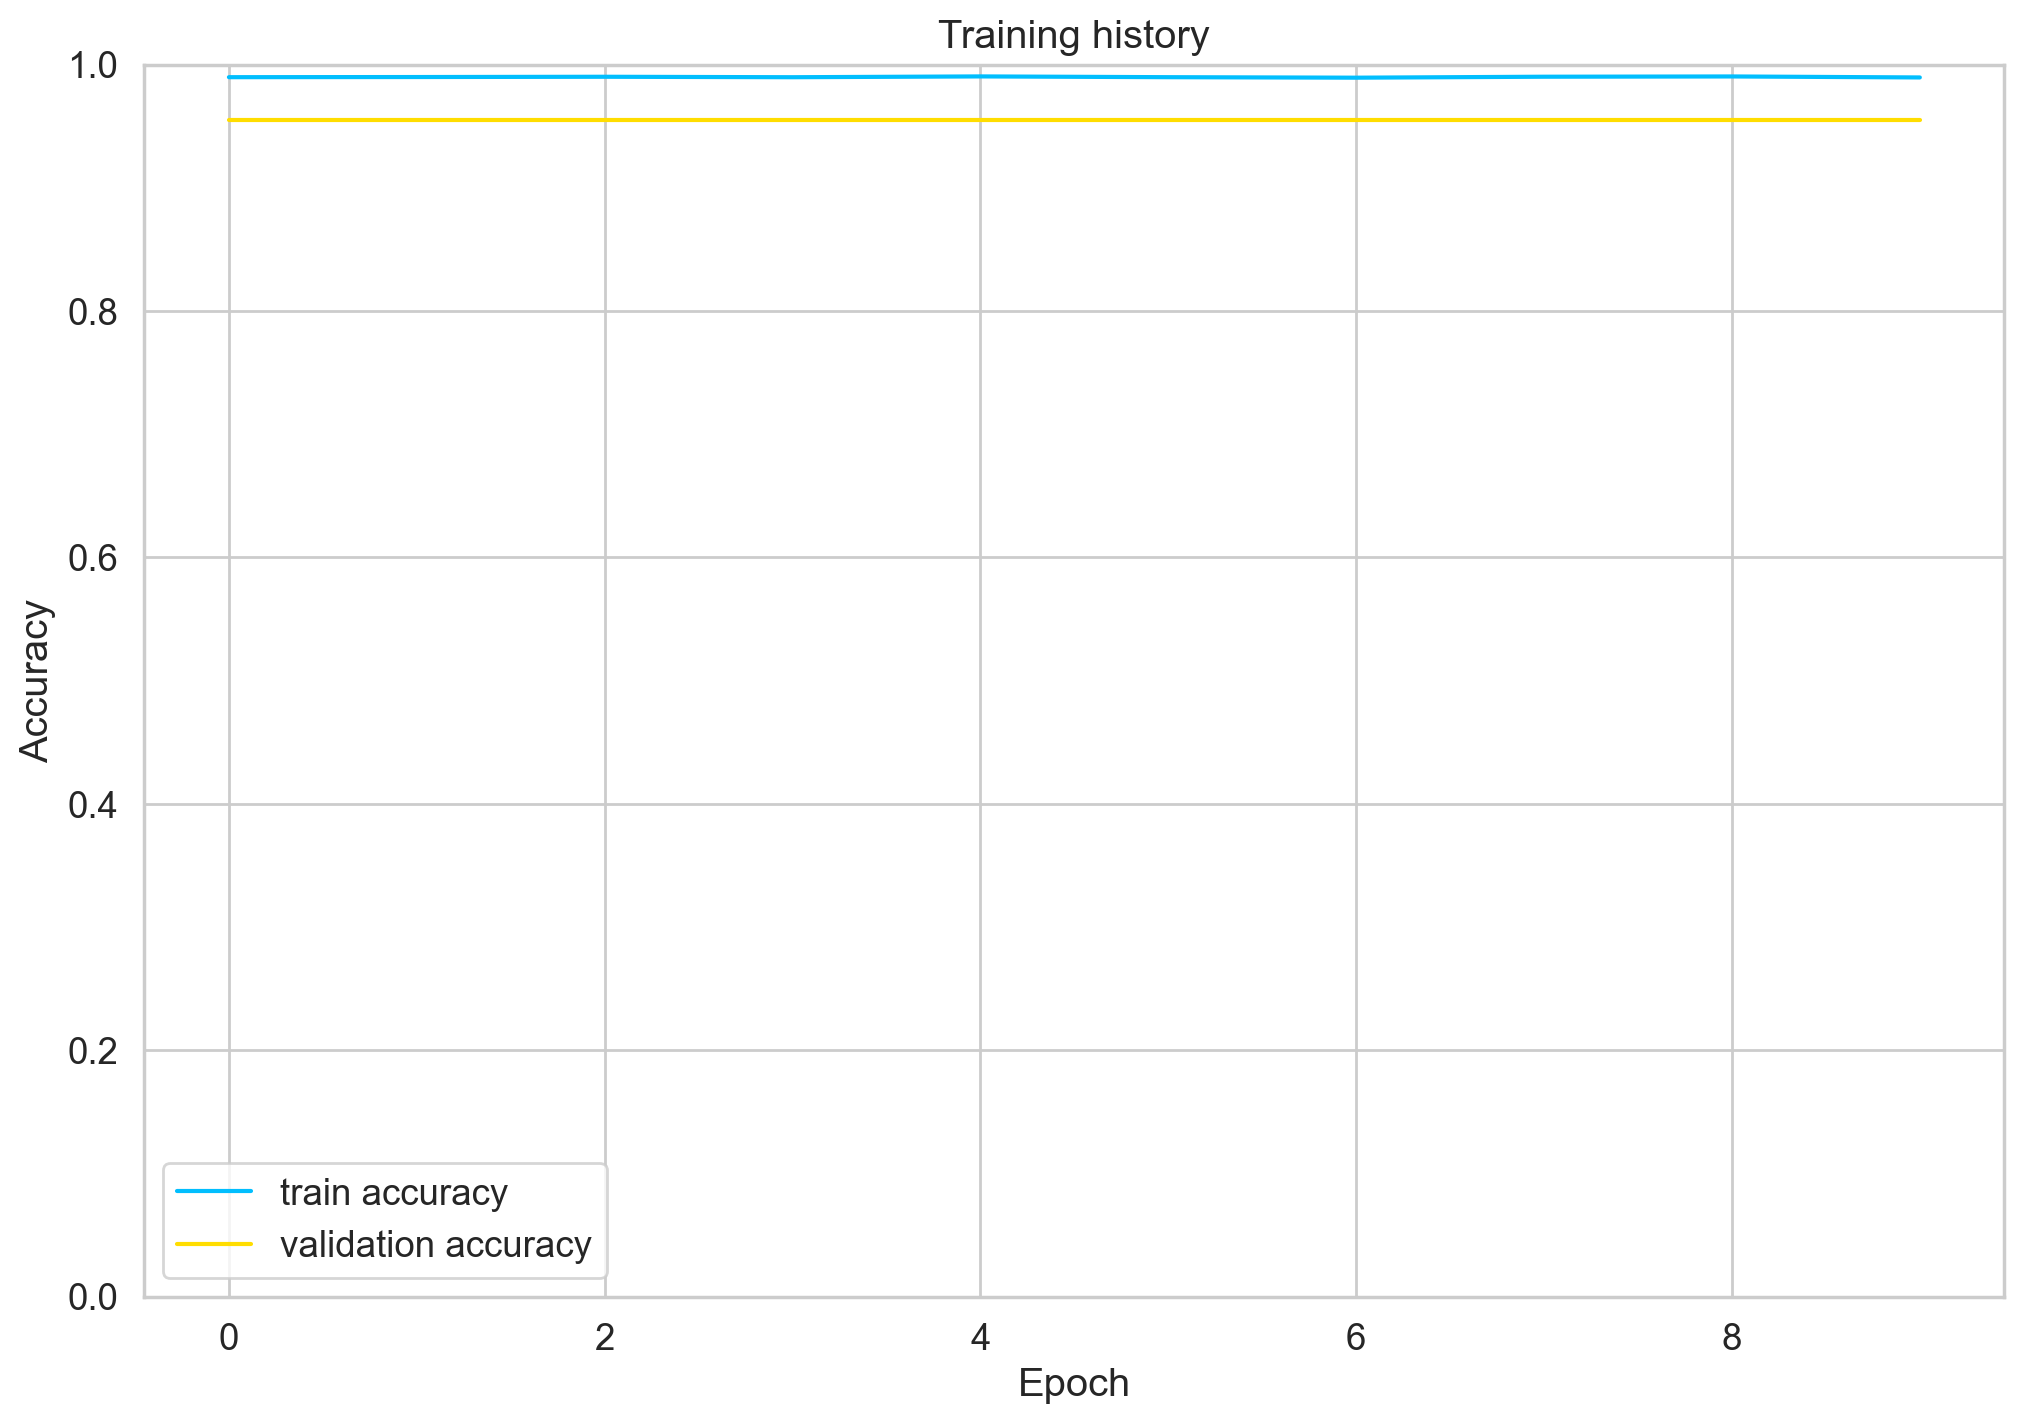

In [40]:
# Ensure your history dictionary contains lists of Python floats, not PyTorch tensors
history['train_acc'] = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['train_acc']]
history['val_acc'] = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in history['val_acc']]

# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [41]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
'''
- Calls the eval_model function to evaluate the model on the test dataset. The function returns the test accuracy and loss. 
Here, only the test accuracy is stored in test_acc, and the loss is ignored (denoted by _).
'''

test_acc.item()
# converts the PyTorch tensor test_acc to a Python scalar using the .item() method. This is useful for printing or logging the accuracy value.

0.9604379198805674

In [42]:
def get_predictions(model, data_loader):
    # Set the model to evaluation mode:
    model = model.eval() # sets the model to evaluation mode, which disables dropout and other training-specific layers.
    
    # Initialize lists to store results
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    #  store the review texts, predicted labels, prediction probabilities, and actual target values.

    # Disable gradient calculation
    with torch.no_grad(): # disables gradient calculation, which reduces memory consumption and speeds up computations during inference
        for d in data_loader: # Iterate over the data loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            ''' 
            - iterates over batches of data from the data_loader. It extracts the review texts, input IDs, attention masks, and target values, 
            moving the tensors to GPU
            '''

            # Get model outputs:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            ''' 
            The model processes the input IDs and attention masks to produce outputs. 
            The torch.max function is used to get the predicted labels (preds) by finding the index of the maximum value along dimension 1.
            '''
            
            # Store results
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            '''
            The extracted texts, predicted labels, prediction probabilities, and actual target values are appended to their respective lists.
            '''

    # Convert lists to tensors
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    # The lists of predictions, prediction probabilities, and real values are converted to tensors and moved to the CPU.
    

    return review_texts, predictions, prediction_probs, real_values

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)
''' 
 calls the get_predictions function with the model and test_data_loader as arguments. The function returns four values, which are then assigned 4
to the variables y_review_texts, y_pred, y_pred_probs, and y_test
- y_review_texts: the review texts from the test dataset.
- y_pred: the predicted labels for the test dataset.
- y_pred_probs: store the prediction probabilities for each class.
- y_test:  actual target values (true labels) from the test dataset.
'''


In [44]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.94      0.98      0.96      2018
    positive       0.98      0.94      0.96      2001

    accuracy                           0.96      4019
   macro avg       0.96      0.96      0.96      4019
weighted avg       0.96      0.96      0.96      4019



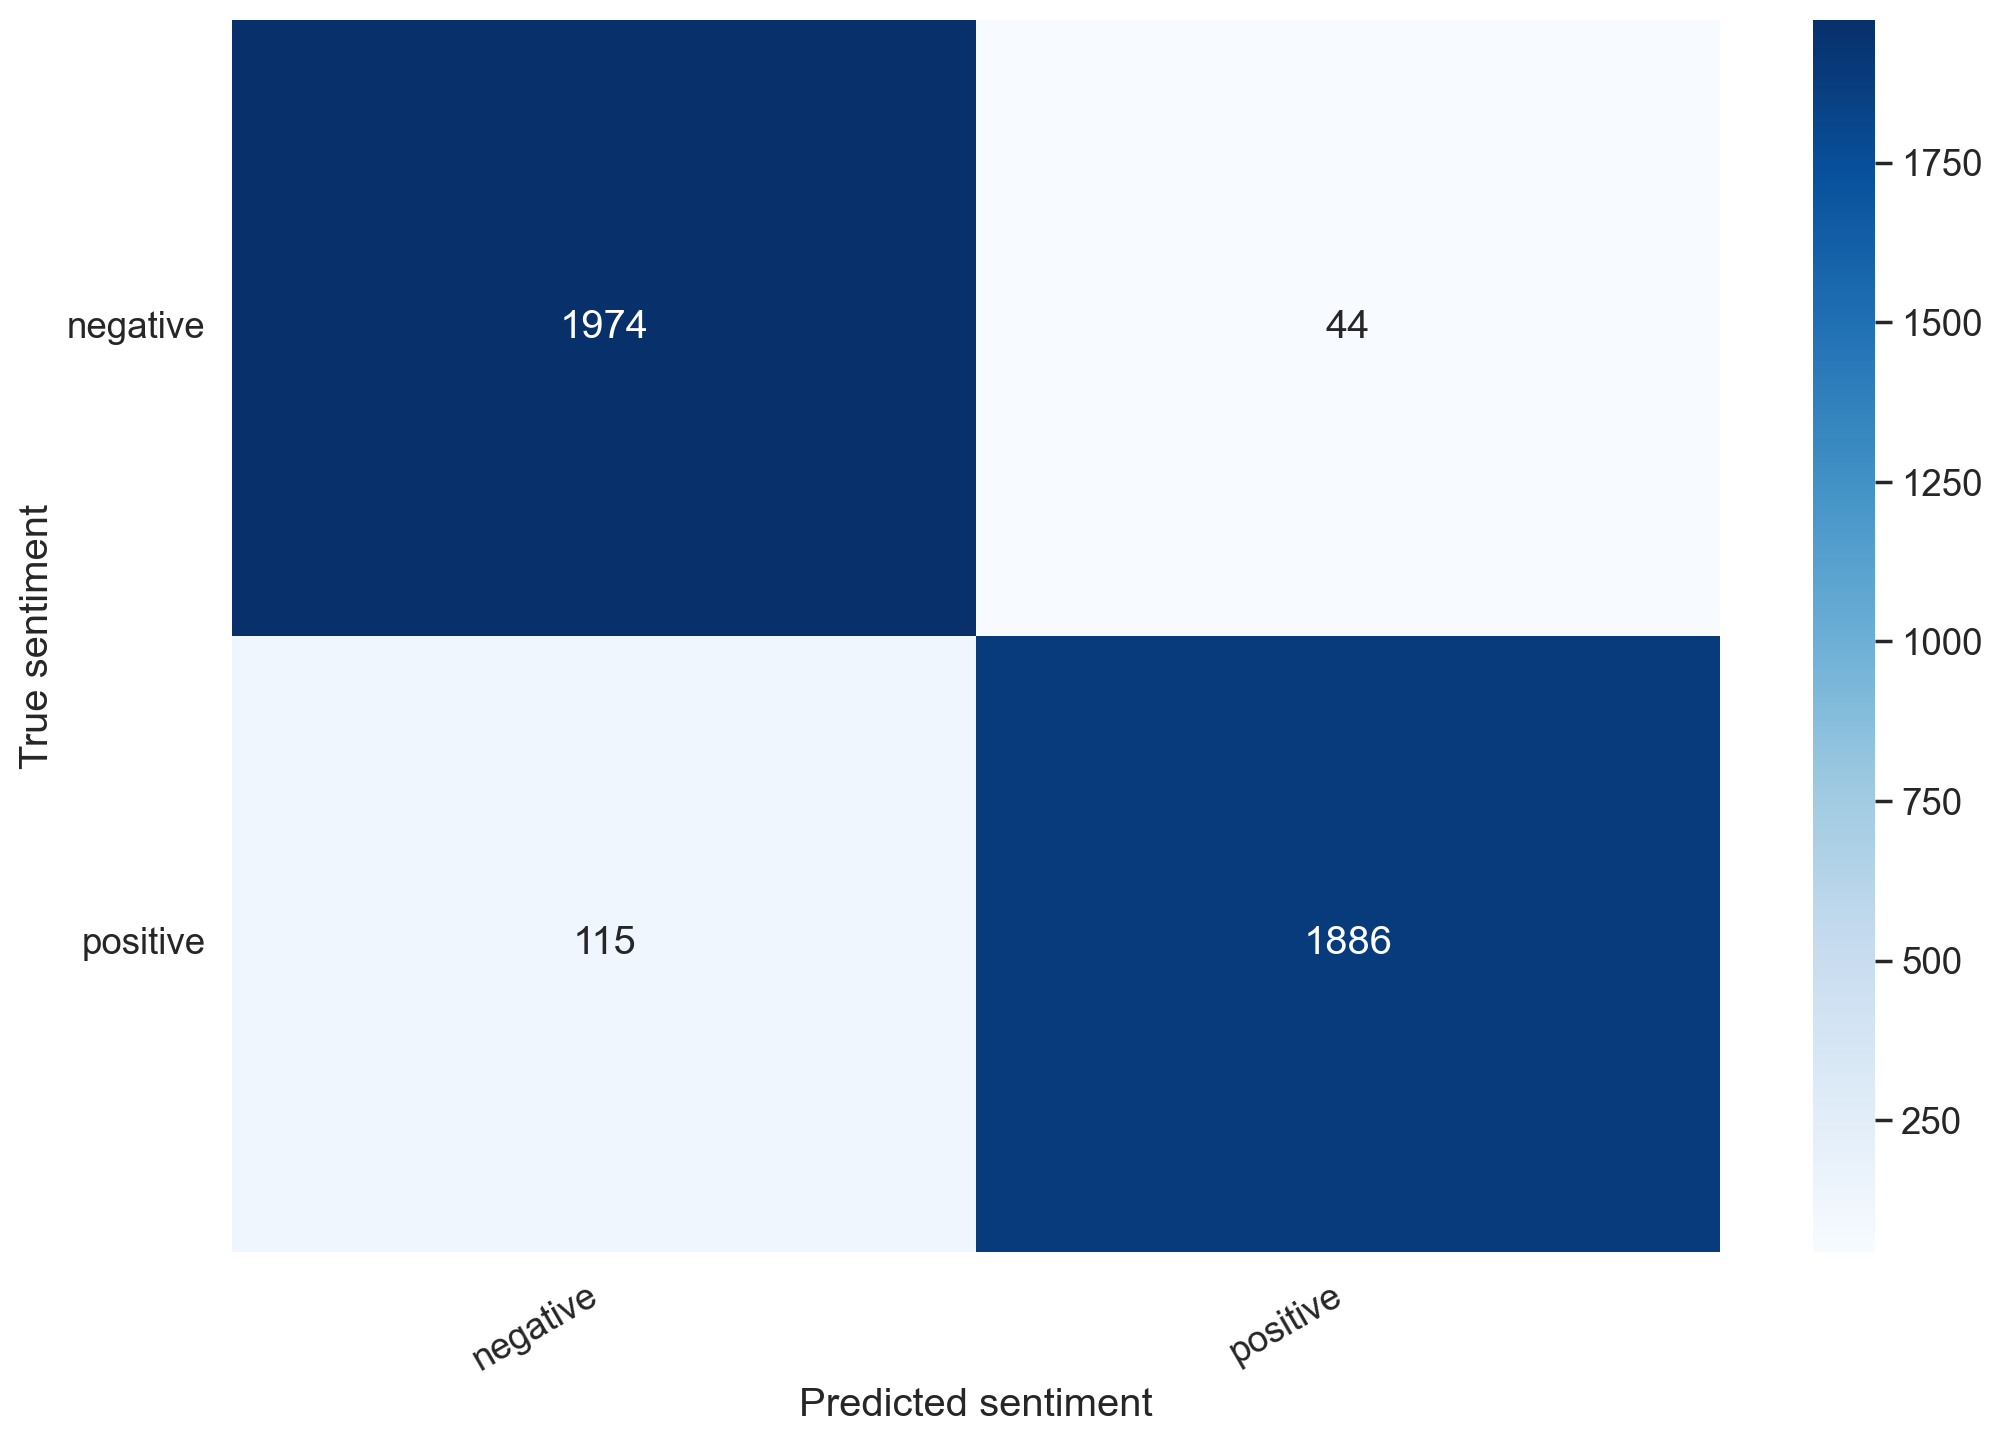

In [45]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [58]:
# review_text = "I love completing my todos! Best app ever!!!"
review_text = "Quần vừa vặn"

In [59]:
encoded_review = tokenizer.encode_plus(
    review_text,
    '''
    Uses the tokenizer.encode_plus method from the Hugging Face Transformers library to tokenize and encode the review_text. 
    The tokenizer is typically a pre-trained tokenizer like BERT’s tokenizer.
    '''
    
    max_length=MAX_LEN,
    '''
    sets the maximum length of the tokenized sequence. If the sequence is longer than MAX_LEN, it will be truncated. 
    If it’s shorter, it will be padded.
    '''
    
    add_special_tokens=True,
    '''
    ensures that special tokens like [CLS] (classification token) and [SEP] (separator token) are added to the sequence
    '''
    
    return_token_type_ids=False,
    '''
    indicates whether to return token type IDs. Since it’s set to False, token type IDs are not returned. Token type IDs are used in tasks like sequence classification to 
    distinguish between different sequences.
    '''
    
    pad_to_max_length=True,
    '''
    ensures that the sequence is padded to the maximum length (MAX_LEN). Padding tokens are added to the end of the sequence if it’s shorter than 
    MAX_LEN
    '''
    
    return_attention_mask=True,
    ''' 
    indicates whether to return the attention mask. The attention mask is a binary mask that differentiates between real tokens (1) and padding tokens (0).
    '''
    return_tensors='pt',
    # specifies the format of the returned tensors. 'pt' indicates that the tensors should be returned as PyTorch tensors.
)


In [60]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
''' 
move the input_ids and attention_mask tensors to GPU. This is necessary for ensuring that the tensors and the model are on the same device for computation.
'''

output = model(input_ids, attention_mask)
# passes the input_ids and attention_mask through the model to get the output. The output typically contains the logits (raw, unnormalized scores) for each class.
_, prediction = torch.max(output, dim=1)
'''
used to find the index of the maximum value along dimension 1 (the class dimension) of the output tensor. This index corresponds to the predicted class. 
The underscore (_) is used to ignore the maximum values themselves, as we are only interested in the indices.
'''

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
'''
The class_names list contains the names of the classes (e.g., “positive”, “negative”), and prediction is used to index into this list to get the predicted sentiment.
'''

Review text: Quần vừa vặn
Sentiment  : positive


In [61]:
torch.save(model,'bert-sampling(16-2nd).pt')


In [62]:
# import torch
# import torch.nn as nn
# from transformers import BertModel

# class SentimentClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(SentimentClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.drop = nn.Dropout(p=0.3)
#         self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

#     def forward(self, input_ids, attention_mask):
#         bert_output = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )
#         pooled_output = bert_output.pooler_output
#         output = self.drop(pooled_output)
#         return self.out(output)

# # Save the model's state dictionary
# model = SentimentClassifier(n_classes=2)
# torch.save(model.state_dict(), 'bert1_2.pt')

# # Load the saved model
# model = SentimentClassifier(n_classes=2)
# model.load_state_dict(torch.load('bert1_2.pt'))
# model.eval()

# # Prepare the input data
# class_names = ['negative', 'positive']
# input_text = "This product is good"

# def preprocess_input(input_text):
#     # Implement the logic to preprocess the input text
#     # For example, tokenize the text and convert it to a tensor
#     input_ids = torch.tensor([101, 2023, 2003, 1996, 102])
#     attention_mask = torch.tensor([1, 1, 1, 1, 1])
#     return input_ids, attention_mask

# input_ids, attention_mask = preprocess_input(input_text)

# # Make a prediction
# with torch.no_grad():
#     output = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))

# # Process the output
# predicted_class = torch.argmax(output).item()
# sentiment_label = class_names[predicted_class]

# print(f"The sentiment of the input text is: {sentiment_label}")